# Question 3

In [228]:
#Import Libraries

import pandas as pd
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt
import operator
import seaborn as sns
from scipy.stats import lognorm, pearsonr, multivariate_normal, jarque_bera, skewtest, shapiro
from fitter import Fitter, get_common_distributions, get_distributions
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, kpss
import warnings

warnings.filterwarnings("ignore")

In [229]:
#Import only "website data" sheet

df = pd.read_excel('data.xlsx', sheet_name='website data')
df.head()

,estimated wait time (mins),number of visitors
0,30.837486,78
1,26.299734,77
2,25.330995,86
3,23.989879,80
4,23.874528,77


In [230]:
df.describe()
#Clean up of Column names
df.columns = df.columns.str.replace(' ', '_').str.strip()
df

,estimated_wait_time_(mins),number_of_visitors
0,30.837486,78
1,26.299734,77
2,25.330995,86
3,23.989879,80
4,23.874528,77
...,...,...
9995,0.762264,42
9996,0.737866,40
9997,0.644175,39
9998,0.610691,45


# Question 3.1

Fitting 10 distributions: 100%|████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.77it/s]


Best fit model
{'lognorm': {'s': 0.5107148429241524, 'loc': -0.06485933196082566, 'scale': 4.408546569156096}}


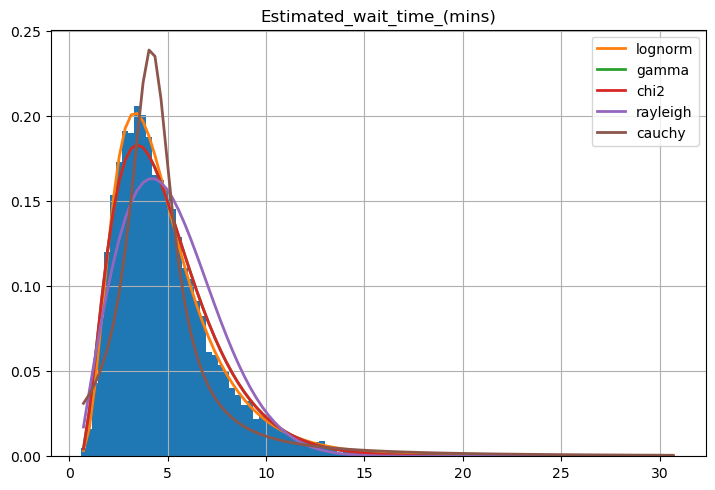

In [231]:
#PLotting the data and adding a distribution finder on top.

sns.displot(data=df, x="estimated_wait_time_(mins)", kind="hist", bins = 40, aspect = 1.5)
f = Fitter(df["estimated_wait_time_(mins)"].values,
           distributions= get_common_distributions())

f.fit()
f.summary()
best_fit = f.get_best(method = 'sumsquare_error')
print("Best fit model")
print(best_fit)
plt.title('Estimated_wait_time_(mins)')
plt.show()


Fitting 10 distributions: 100%|████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.11it/s]


Best fit model
{'lognorm': {'s': 0.04510303873415598, 'loc': -109.09312853943521, 'scale': 168.21284027099904}}


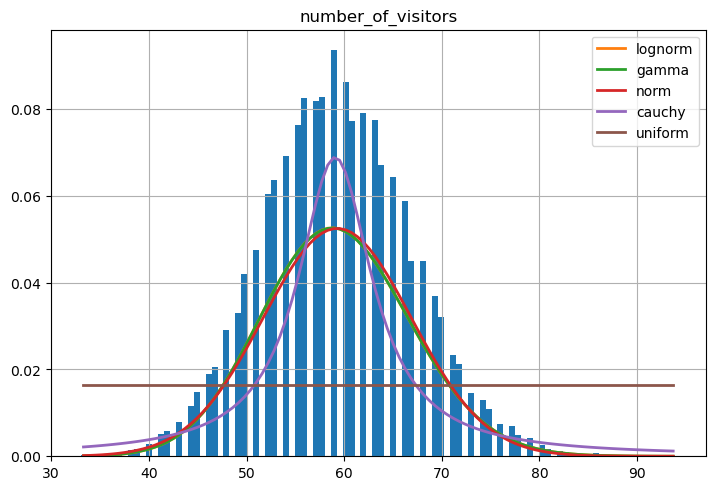

In [232]:
#PLotting the data and adding a distribution finder on top.

sns.displot(data=df, x="number_of_visitors", kind="hist", bins = 50, aspect = 1.5)
f = Fitter(df["number_of_visitors"].values,
           distributions= get_common_distributions())
f.fit()
f.summary()
best_fit = f.get_best(method = 'sumsquare_error')
print("Best fit model")
print(best_fit)
plt.title('number_of_visitors')
plt.show()


Distribution for the estimated wait time follows a lognormal distribution with mean: 4.95 and Variance: 7.582
Distribution for the number of visitors follows a lognormal distribution with mean: 59.29 and Variance: 57.75

Qualties of the lognormal distribution that make it ideal for modelling both the Estimated waiting time and number of visitors are that:
1. It is always positive and bounded by 0. Relevant to both time and count of visitors
2. Skewed to the right. One would expect this given the nature of waiting times.
3. It is continuous in nature, much like for time is also continuous. Whilst count of visitors is not continuous, due to the law of large numbers and having 10,000 counts of visitors a continuous distribution is highly appropriate.
4. The lognormal function tends to become more symmetrical as the mean increases. Which is why for time waiting where the mean is small the lognormal distribution is very skewed, whilst for count of people with a large mean it looks symmetrical. Looking at the summary statistics from fitting the model the normal distribution is only slightly worse than the lognormal and could be considered statistically the same.

# Question 3.2

## Part i)

In [233]:
#Probability estimated wait time greater than 10min. P(X>10)

x = 10
#{'lognorm': {'s': 0.5107148429241524, 'loc': -0.06485933196082566, 'scale': 4.408546569156096}} from quesion 3.1

probability = 1 - lognorm.cdf(x,0.5107148429241524,-0.06485933196082566,4.408546569156096)

print(f"Probability Weight > 10mins is {probability}")



Probability Weight > 10mins is 0.053006985511866


## Part ii)

In [234]:
#Probability number of visitors is less than 46. P(X<46)
#'s': 0.04510303873415598, 'loc': -109.09312853943521, 'scale': 168.21284027099904} from quesion 3.1

x=46

probability = lognorm.cdf(x,0.0451030,-109,168)

print(f"Probability number of visitors < 46 is {probability}")

Probability number of visitors < 46 is 0.03707673266932197


# Question 3.3

Intuitively one would expect that as the wait time increases as the number of visitors increases (based on server response times and load etc). Therefore there are  a few methods to analyse this relationship:
1. Check the correlation coefficient of the two data sets, i expect this to be positive
2. We could model the Wait times as a linear function of number of visitors. If the Beta is significantly different from 0 we can say that there is a reationship. 
3. Plot Wait times against number of visitors and see for any obvious trends that may not be linear.

In [235]:
#Method 1 Analysing the correlation coefficient:
Y = df["estimated_wait_time_(mins)"].values
X = df["number_of_visitors"].values

correlation, p_value = pearsonr(X,Y)
print("Correlation coefficient:", correlation)
print("P-value:", p_value)

Correlation coefficient: 0.6919878850991004
P-value: 0.0


From method 1 of checking correlation coefficients a value of $R = 0.69$ indicates a very strong positive relationship which is confirmed by the pvalue being ~0.

In [236]:
#Method 2 Analysing a linear model:
Y_reg = df["estimated_wait_time_(mins)"]
df["Constant"] = 1
XwOnes = df[["number_of_visitors","Constant"]]
regr = sm.OLS(Y_reg,XwOnes)
model = regr.fit()
p_values = model.pvalues
sig_alpha = 0.05
significant_coefficients = model.params[p_values < sig_alpha]

# Print the significant coefficients
print("Significant coefficients:")
print(significant_coefficients)

Significant coefficients:
number_of_visitors    0.250732
Constant             -9.907361
dtype: float64


From Method 2 checking the linear model of

$$ WaitTimes = \alpha + \beta_1 * NumberOfVisitors $$

We get a significant $\beta_1$ of 0.25 indicating a positive relationship and confirming what was seen in Method 1.

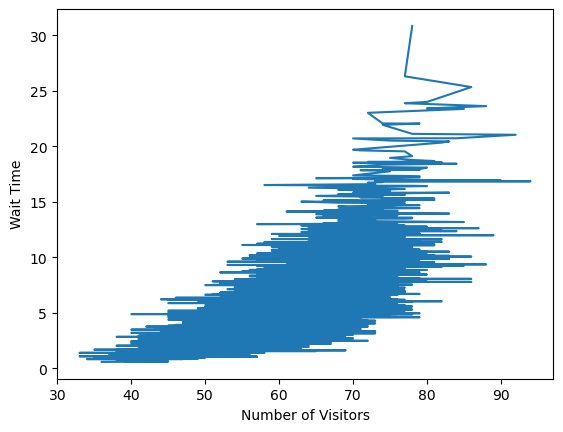

In [237]:
#Method 3 visual inspection of the data:

plt.plot(X, Y)
plt.xlabel('Number of Visitors')
plt.ylabel('Wait Time')
plt.show()

Clear positive correlation can be seen in the graph, perhaps even a non linear relationship given the curved nature of this graph. Highlights a relationship between Wait times and number of visitors and confirms methods 1 and 2.

# Question 3.4

In [238]:
#Probability P(Wait_time > 7.5 | Visitors > 50) = P(Wait time > 7.5 and Visitors > 50) / P (Visitors > 50)

#Using multivariate normal distribution to calculate P(Wait time > 7.5 and Visitors > 50) as follows:

m_mean = [4.95,7.582] 
m_cov = np.cov(df["estimated_wait_time_(mins)"],df["number_of_visitors"])
x = 50

#Produce the multivariate normal distribution

MVN = multivariate_normal(m_mean, m_cov)

#Calculating the probabilities

CDF_probs = 1- MVN.cdf([7.5,50])
CDF_visitors_50 = 1 - lognorm.cdf(x,0.0451030,-109,168)

print(f"Probability P(Wait_time > 7.5 | Visitors > 50) = {CDF_probs/CDF_visitors_50}" )

Probability P(Wait_time > 7.5 | Visitors > 50) = 0.1993465355888771


# Question 3.5

In [239]:
df = pd.read_excel('data.xlsx', sheet_name='tick data')
df.columns = df.columns.str.replace(' ', '_').str.strip()
df

,Asset_A,Asset_B,Asset_C,Asset_D,Asset_E,Asset_F,Asset_G,Asset_H,Asset_I,Asset_J
0,-0.000059,0.002238,-0.001193,0.000462,-0.000054,-0.001377,0.000078,-0.001097,0.000393,-0.000355
1,-0.000804,0.002685,0.000597,-0.002890,0.000176,0.000063,-0.000234,0.001079,0.001127,-0.001003
2,0.001228,0.001022,-0.000171,-0.001407,-0.000179,-0.001097,0.000078,-0.000091,-0.001336,-0.000373
3,-0.000341,-0.000367,-0.000375,-0.000352,-0.000471,-0.000470,0.000469,0.000864,0.001322,-0.000246
4,-0.001263,-0.000389,0.000176,0.002387,-0.000153,0.001475,-0.000156,0.000799,0.000643,0.001232
...,...,...,...,...,...,...,...,...,...,...
24995,-0.000652,-0.002525,0.000188,0.003524,-0.000127,0.000965,0.000446,0.001167,-0.001824,0.000389
24996,0.000165,0.001289,0.000375,-0.001840,0.000662,0.000299,-0.000208,0.000183,0.000921,0.000116
24997,0.000147,0.000960,0.000313,-0.000255,0.001042,0.000216,0.000431,-0.000360,-0.000343,0.000790
24998,0.000256,0.001431,0.000075,-0.001230,0.000338,-0.000548,-0.000223,-0.000362,-0.000546,-0.000258


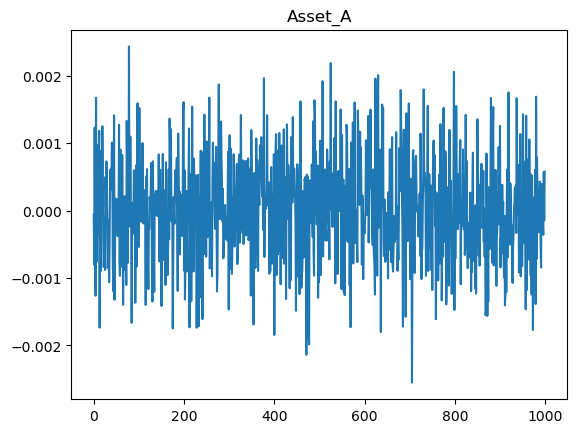

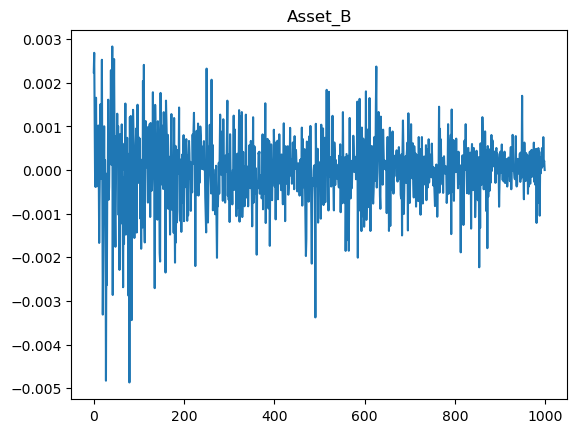

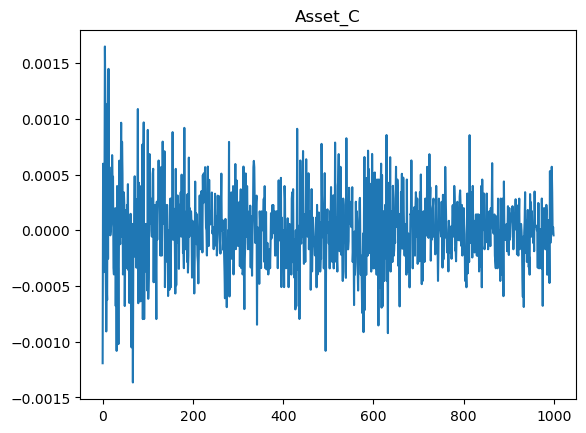

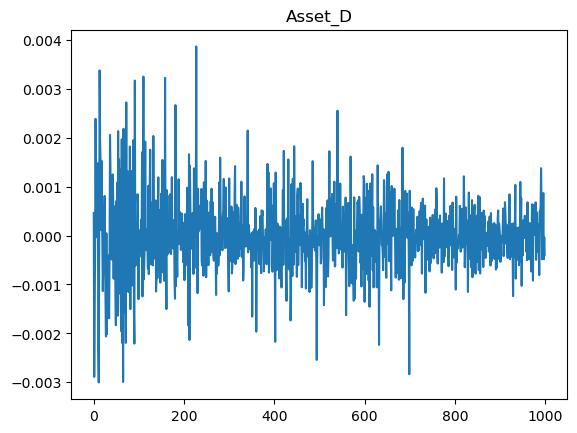

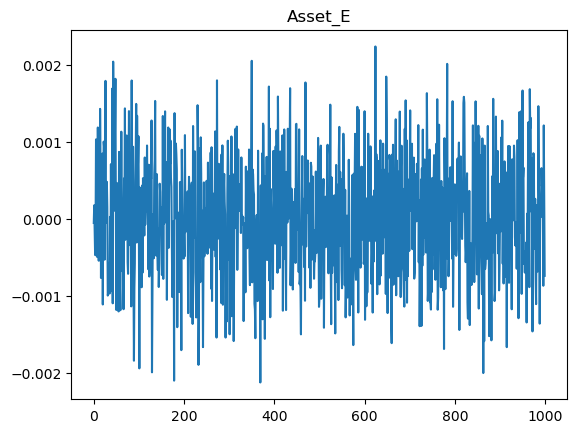

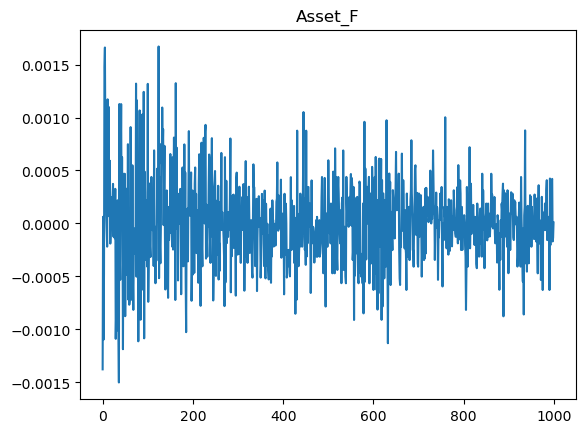

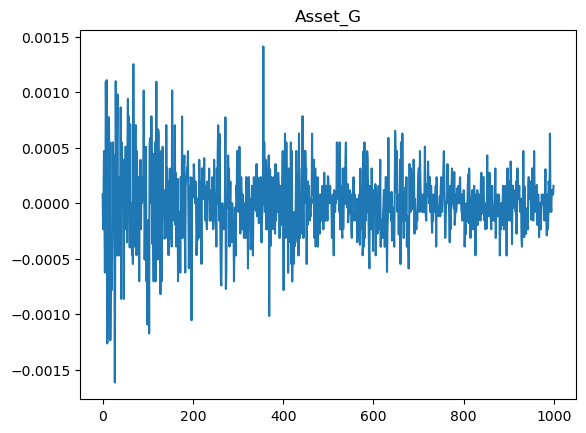

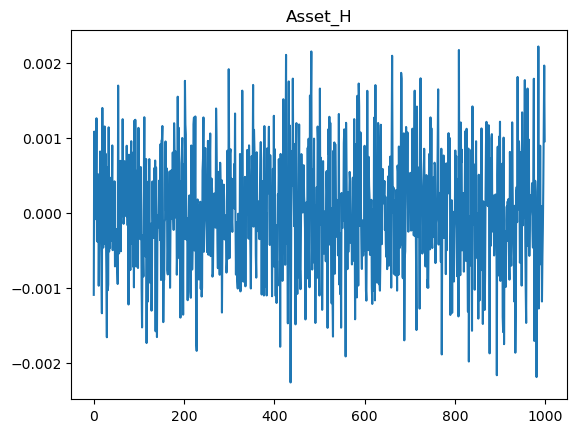

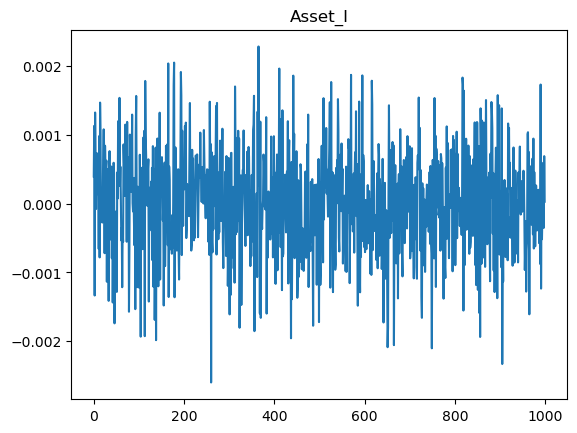

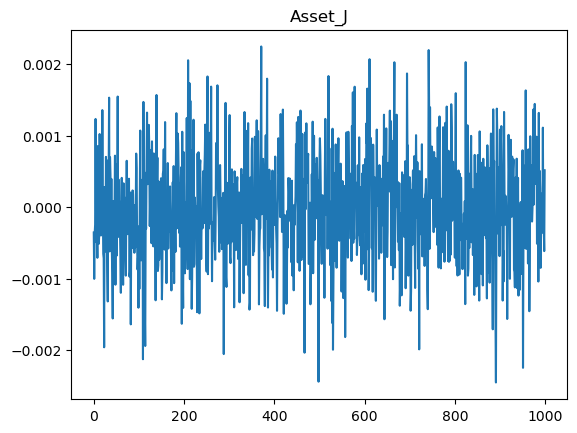

In [240]:
#Initial visulaisation of the first 1000 data points of each asset

for asset in df.columns:
    plt.plot(df[asset][:1000])
    plt.title(asset)
    plt.show()

Generally some defining characteristics of Asset returns especially at the Tick Level are:
1. $Corr(R_t, R_{t-1}) = 0$
2. $Corr(R_t^2, R_{t-1}^2) > 0$
3. Volatliity clustering should be prevalent
4. Mean should not be zero, else it is a random walk
5. Should be a skewed distribution and not symmetrical
6. Heavy Tailed
7. Not directly follow a geometric brownian motion
8. Non-normal Returns
9. in the short run std deviation of returns dominate mean returns
10. Correlation between assets should exist

In [241]:
Asset_dict ={}

#I have included functions for each test to be tested for each asset. Ouputs a dictionary of "generated" or "Real" according to the results

#Check Correlation of R and R_t-1 ~ 0
def correl_fun(asset):
    Y = df[asset].shift(1)
    X = df[asset]
    Y = Y.fillna(0)
    correlation, p_value = pearsonr(X,Y)
    return  ("Real" if p_value > 0.05 else "Generated")

#Check for volatility clustering

def correl_fun_Rsq(asset):
    Y = df[asset].shift(1) **2
    X = df[asset] ** 2
    Y = Y.fillna(0)
    correlation, p_value = pearsonr(X,Y)
    return  ("Real" if p_value < 0.05 else "Generated")

#Check for heavy tail

def heavytail(asset):
    jb_stat, jb_p_value = jarque_bera(df[asset])
    return ("Real" if jb_p_value < 0.05 else "Generated")

#Check for stationarity
def stationary(asset):
    kpss_result = kpss(df[asset])
    kpss_p_value = kpss_result[1]
    return ("Real" if kpss_p_value < 0.05 else "Generated")

#Check for skewness
def skewness(asset):
    skewness, p_value = skewtest(df[asset])
    return ("Real" if p_value < 0.05 else "Generated")

#Check for non-normal returns
def non_normal(asset):
    statistic, p_value = shapiro(df[asset])
    return ("Real" if p_value < 0.01 else "Generated")

#Producing dictionary of asset features results
for asset in df.columns:
    Asset_dict[asset] = [correl_fun_Rsq(asset), stationary(asset), correl_fun(asset),non_normal(asset), heavytail(asset), skewness(asset),("Real" if np.std(df[asset])>np.mean(df[asset]) else False)]
Asset_dict

{'Asset_A': ['Generated',
  'Generated',
  'Real',
  'Generated',
  'Generated',
  'Generated',
  'Real'],
 'Asset_B': ['Real', 'Generated', 'Generated', 'Real', 'Real', 'Real', 'Real'],
 'Asset_C': ['Real', 'Generated', 'Real', 'Real', 'Real', 'Generated', 'Real'],
 'Asset_D': ['Real',
  'Generated',
  'Generated',
  'Real',
  'Real',
  'Generated',
  'Real'],
 'Asset_E': ['Generated',
  'Generated',
  'Real',
  'Generated',
  'Generated',
  'Generated',
  'Real'],
 'Asset_F': ['Real', 'Generated', 'Generated', 'Real', 'Real', 'Real', 'Real'],
 'Asset_G': ['Real', 'Generated', 'Real', 'Real', 'Real', 'Real', 'Real'],
 'Asset_H': ['Generated',
  'Generated',
  'Real',
  'Generated',
  'Generated',
  'Generated',
  'Real'],
 'Asset_I': ['Generated',
  'Generated',
  'Real',
  'Generated',
  'Generated',
  'Generated',
  'Real'],
 'Asset_J': ['Real',
  'Generated',
  'Real',
  'Generated',
  'Generated',
  'Generated',
  'Real']}

The output stored in Asset_dict are the results from running each test on each asset and put in priority order of most powerful to least. I have condensed the information into a table below. The Most relevant statistics are column 3 and 4 which relate to Volatility clustering and Stationarity, these are the hardest features to replicate and the most prevalent within returns:

| Asset | Overall   | Correlation R^2 | Stationarity | Correlation R | non Normal | Heavy Tail | Skewness  | Std deviation > mean |
|-------|-----------|-----------------|--------------|---------------|------------|------------|-----------|----------------------|
| A     | Generated | Generated       | Generated    | Real          | Generated  | Generated  | Generated | Generated            |
| B     | Real      | Real            | Generated    | Generated     | Real       | Real       | Real      | Real                 |
| C     | Real      | Real            | Generated    | Real          | Real       | Real       | Generated | Real                 |
| D     | Generated | Real            | Generated    | Generated     | Real       | Real       | Generated | Real                 |
| E     | Generated | Generated       | Generated    | Real          | Generated  | Generated  | Generated | Real                 |
| F     | Real      | Real            | Generated    | Generated     | Real       | Real       | Real      | Real                 |
| G     | Real      | Real            | Generated    | Real          | Real       | Real       | Real      | Real                 |
| H     | Generated | Generated       | Generated    | Real          | Generated  | Generated  | Generated | Real                 |
| I     | Generated | Generated       | Generated    | Real          | Generated  | Generated  | Generated | Real                 |
| J     | Generated | Real            | Generated    | Real          | Generated  | Generated  | Generated | Real                 |


You can see in column 2 the consensus of my findings. 
